# **The Grover Search Algorithm**
***


Like the previous algorithms we’ve studied, at the heart of
the Grover Algorithm is a Hadamard Transformation. However, this algorithm does not solve a ’blackbox’ problem, making it
different from our previous lab sessions. Instead, we will be solving a searching problem, whereby we would like to locate one
particular state with a measurement, out of $2^N$ .

Grover's Algorithm is a quantum based algorithm that can locate a value or element in an unsorted set in O($\sqrt N$) time, as opposed to classical search algorithms, which can find an element only in O($N$) time.

Original Publication: [A fast quantum mechanical algorithm for database search](https://arxiv.org/abs/quant-ph/9605043)


Fun Fact: Lov Grover received his BTech in Electrical Engineering from IIT Delhi in 1981.

## **Scenario** 
Imagine you want to look someone up in a directory, which is alphabetically ordered by last name, but you only have their first name. In this scenario, you are stuck going through each entry one at a time, until you eventually happen upon the person you are looking for.
Exhaustively searching through the database represents the classical approach, which requires on average N/2 evaluations, which
is of the order O($N$). By instead using the Grover Algorithm, we can complete this search (with a high success probability)
using only O($\sqrt N$) evaluations.

## **Setting Up the Problem**

Our goal is to create a quantum algorithm that will allow us to pick any state we want (within the $2^N$ space), and then attempt to find that state with a single measurement. As we shall see, we will measure our desired state, which we shall refer to as our **’marked state’**, with a high success probability. In addition, larger systems will result in higher success probabilities, a nice feature that is unique to the quantum approach!

## **The Grover's algorithm can be broadly classified into 4 major steps:**

1. Initialise the Quantum circuit by creating a superposition of all qubits using Hadamard gate. 
2. Create an oracle to highlight the state you want to find. This oracle operates by conducting a phase flip, which inverts the amplitude of the state.
3. Create an amplification circuit that raises (increases) the amplitude of the marked (highlighted) states while at the same time lowering (decreases) the amplitude of the other states.
4. Measurement

### **Step 1: Initialise the Quantum Circuit. Create a superposition of qubits using Hadamard gate**

Like the classical search, our quantum algorithm needs to first reflect the problem of having no a priori knowledge of where the marked entry is located. For our quantum algorithm, we can represent this by starting our system in an equal superposition of all states. Thus, the starting point for our code will be to specify the size of our problem, and then create an equal superposition:

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute,IBMQ,Aer
import math
from qiskit.tools.monitor import job_monitor

# IBMQ.enable_account('Enter Token From IBM account')
# provider = IBMQ.get_provider(hub='ibm-q')
        
pi = math.pi
q = QuantumRegister(4,'q')
c = ClassicalRegister(4,'c')
qc = QuantumCircuit(q,c)

### Initialisation ###
N  = 4 

for i in range(N):
  qc.h(q[i])


In the code above, we specify the size of our problem with the parameter N , creating a quantum system of the size $2^N$ . N is the number of qubits we will be using, which means we can create significantly large systems with only a minimal amount of qubits. We prepare our system in an equal superposition of all $2^N$ states by applying a Hadamard gate to each qubit, creating the
following initial state:

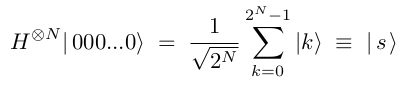

Now, let’s do some simulated measurements on this state. These measurements represent the classical approach of picking blindly until we happen on our desired state:

In [2]:
qc.measure(q,c)

M_simulator = Aer.backends(name='qasm_simulator')[0]


job = execute(qc,M_simulator)
result = job.result()
result.get_counts(qc)

{'0100': 58,
 '1101': 69,
 '1000': 62,
 '0000': 66,
 '1100': 62,
 '0101': 68,
 '0110': 58,
 '0111': 63,
 '0011': 68,
 '1010': 66,
 '1110': 58,
 '0001': 66,
 '1011': 71,
 '1111': 62,
 '1001': 67,
 '0010': 60}

Take a look at the measurement counts for each state and verify that all states in the system are equally probable (although it’s rare to get a perfectly even distribution). Using a quantum system like this to find a specific state is quite slow, and in fact it’s even worse than the classical analog!

The main advantage to a classical search is the ability to ’remember’ past measurements, and remove them from the problem. By doing so, the classical approach will slowly narrow down the pool of possible entries, until eventually finding the desired one. When using a quantum approach, we can’t do this. If we measure the state $|110⟩$, that’s it. Our wavefunction collapses to
that state, and we’ve failed our search. And, when we go to prepare the system the next time, we have no way of removing the state $|110⟩$ from the system, which means we could get it again!

The difference between the classical and quantum approaches to a search problem are very noteworthy. Since our quantum system has no memory of past measurements, we can only hope to find our desired state with a single attempt. **Thus, the goal of the Grover Algorithm will be to boost our chance of measuring the desired state**.

### **Step 2: Create the desired Oracle**



Now that we have our equal superposition of $2^N$ states, we can begin to construct our Grover Algorithm.


To do this, the first thing we need is an operator $U_w$ , known as an 'oracle'. Simply put, this is an operator that picks out a single state in the system, say $|0101⟩$, and applies an operation. Specifically, this oracle operator $U_w$ isolates a single state such that it is the only state in the system that will then receive the desired operation.

By default, control gates only pick out states where all
of the control qubits are in the state |1⟩, for example when N=3:

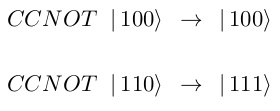

For our Grover algorithm, we need our oracle to be able to pick out any state, including states with 0’s on any qubit.

In order to make sure that only our marked state is the control-state, we will perform a series of X gates to transform our marked
state to the state of all 1’s: $|111...1⟩$. Simultaneously, this transformation will also guarantee that our marked state is the only
state in the system of all 1’s. Thus, when we apply our N-qubit control gate operation, its effect will only get applied to our
marked state. Then, we will transform all of the states back to the original basis, using the same X gates:

Equally as important as the transformation of the marked state, is the effect of this transformation on the rest of the system. For
example, consider the effect of the X Transformation when N = 3 and $|001⟩$ is the marked state:

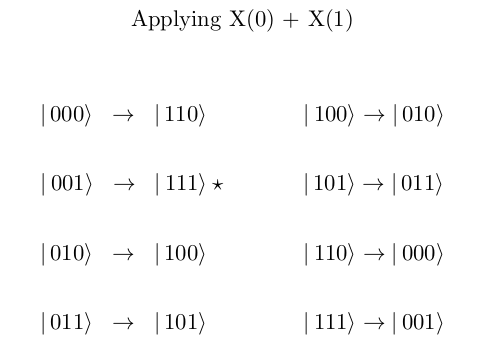

No other state in the system gets mapped to $|111⟩$, exactly the result we need. If we consider that our marked state is ’unique’, in that no other state in the system has the same 0’s and 1’s, it makes sense that the transformation to $|111⟩$ is unique as well, mapping all other states elsewhere.

The last step is the transformation back to our original basis. For our Grover Algorithm, transforming our marked state to $|11...1⟩$ will allow us to apply a higher order control operation, but afterwards, we must transform back in order to search for the marked state in its original form. Lucky for us, the transformation back to our original basis is just as easy. All we need to do is apply the exact same X gates again.

The following code contains the oracles for all possible states. All oracles are commented out except for the oracle which marks 0000. 

As an exercise, just uncomment the oracle you want for the desired state and run the code.

In [3]:
q = QuantumRegister(4,'q')
c = ClassicalRegister(4,'c')
qc = QuantumCircuit(q,c)

### Initialisation ###
N  = 4 

for i in range(N):
  qc.h(q[i])

### 0000 Oracle ###

qc.x(q[0])
qc.x(q[1])
qc.x(q[2])
qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
qc.x(q[1])
qc.x(q[2])
qc.x(q[3])

'''
### 0001 Oracle ###

qc.x(q[1])
qc.x(q[2])
qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[1])
qc.x(q[2])
qc.x(q[3])
'''

'''
### 0010 Oracle ###

qc.x(q[0])
qc.x(q[2])
qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
qc.x(q[2])
qc.x(q[3])
'''

'''
### 0011 Oracle ###

qc.x(q[2])
qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[2])
qc.x(q[3])
'''

'''
### 0100 Oracle ###

qc.x(q[0])
qc.x(q[1])
qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
qc.x(q[1])
qc.x(q[3])
'''

'''
### 0101 Oracle ###

qc.x(q[1])
qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[1])
qc.x(q[3])
'''

'''
### 0110 Oracle ###

qc.x(q[0])
qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
qc.x(q[3])
'''

'''
### 0111 Oracle ###

qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[3])
'''

'''
### 1000 Oracle ###

qc.x(q[0])
qc.x(q[1])
qc.x(q[2])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
qc.x(q[1])
qc.x(q[2])
'''

'''
### 1001 Oracle ###

qc.x(q[1])
qc.x(q[2])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[1])
qc.x(q[2])
'''

'''
### 1010 Oracle ###

qc.x(q[0])
qc.x(q[2])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
qc.x(q[2])
'''

'''
### 1011 Oracle ###

qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[3])
'''

'''
### 1100 Oracle ###

qc.x(q[0])
qc.x(q[1])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
qc.x(q[1])
'''

'''
### 1101 Oracle ###

qc.x(q[1])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[1])
'''

'''
### 1110 Oracle ###

qc.x(q[0])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
'''

'''
###1111 Oracle###

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
'''

C:\Users\ANURAG SAHGAL\AppData\Local\Temp\ipykernel_2864\1431766398.py:18: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(pi/4, q[0], q[3])
C:\Users\ANURAG SAHGAL\AppData\Local\Temp\ipykernel_2864\1431766398.py:20: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-pi/4, q[1], q[3])
C:\Users\ANURAG SAHGAL\AppData\Local\Temp\ipykernel_2864\1431766398.py:22: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(pi/4, q[1], q[3])
C:\Users\ANURAG SAHGAL\A

'\n###1111 Oracle###\n\nqc.cu1(pi/4, q[0], q[3])\nqc.cx(q[0], q[1])\nqc.cu1(-pi/4, q[1], q[3])\nqc.cx(q[0], q[1])\nqc.cu1(pi/4, q[1], q[3])\nqc.cx(q[1], q[2])\nqc.cu1(-pi/4, q[2], q[3])\nqc.cx(q[0], q[2])\nqc.cu1(pi/4, q[2], q[3])\nqc.cx(q[1], q[2])\nqc.cu1(-pi/4, q[2], q[3])\nqc.cx(q[0], q[2])\nqc.cu1(pi/4, q[2], q[3])\n'

**Sign Flip on $|111...1⟩$ (The Oracle Function)**

The Oracle circuit inverts the state's amplitude, making it -1/4. This is accomplished by first applying a Pauli X gate to specific qubits (depending on the state you wish to mark).

Then, you use a triple-controlled Z gate to Qubit 3.

The Pauli X gate is then applied to the same qubits to which the gates were previously applied.

### **Step 3: Create the Amplification circuit**

**$U_s$ - Grover Diffusion Operator**

The operator that is going to achieve this reflection about the average will be $U_s$ , often referred to as the Grover Diffusion Operator. We will start by writing out the effect of the operation we want:

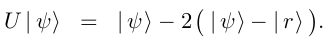

where $|ψ⟩$ is the state of our system, and $|r⟩$ represents an equal superposition of all states, where each state has an amplitude of
$\alpha_{avg}$ :

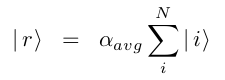

This state $|r⟩$ is most definitely not normalized, meaning we can’t physically create it, but represents what we want to happen as a result from our operation. Specifically, the operation $|\psi⟩$ − 2($|\psi⟩ − |r⟩$) is written this way in order to understand its two components:
1. take the difference in amplitudes between each state and the average:$|\psi⟩ − |r⟩$
2. double each of these differences, and subtract them from the initial amplitudes: $|\psi⟩$ − 2(· · ·).

For example, suppose we have a system where the amplitude for the state $|01⟩$ is $α_{0000}$ = 0.7, and the average amplitude for the whole system is $α_{avg}$ = 0.45. We want the effect of our operation to do the following:



$$U_s|0000⟩ → (0.7 − 2 ( 0.7 − .45 ))|0000⟩ = ( 0.2 )|0000⟩$$

Hopefully this example illustrates what we are going for. We want an operation that uses the difference between each state and the average ($\alpha_i$ − $\alpha_{avg}$),  and subtracts double this amount from the initial amplitude.

If ($\alpha_i$ − $\alpha_{avg}$) is positive, then the final amplitude will be smaller, possibly even negative. Conversely, if ($\alpha_i$ − $\alpha_{avg}$) is negative, then the final amplitude will be larger, which we shall see happens to our marked state.

Now then, let’s see how we can construct this $U_s$ operator. First off, let’s do a little rewriting:



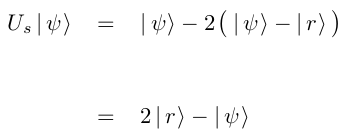

The second part of this operation should stand out to you, it’s just the Identity operator I. Thus, our unitary operator will have the following form:

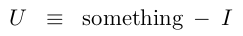

This something, is a operation that when applied to a state $|ψ⟩$, results in the state 2$|r⟩$. As mentioned before, $|r⟩$ is a state that is not guaranteed to be normalized, thus we cannot physically create it. However, the combination of 2$|r⟩$ − $|ψ⟩$ will be normalized.

The matrix operation that creates the state $|r⟩$ is as follows:

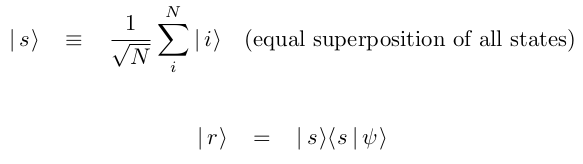

Thus, we can create $|r⟩$ by using the state $|s⟩$, which is definitely a physically realizable state (Hadamard gates on every qubit). However, $|s⟩⟨s|$ is not a unitary operator (if it were, it would mean that we could physically create $|r⟩$. Let’s quickly show how these two quantities are equal:
1. The inner product $⟨s|ψ⟩$ results in the following sum of all the amplitudes: $\frac{1}{\sqrt{N}} \sum^{N}_{i} \alpha_i$
2. We borrow the remaining $\frac{1}{\sqrt{N}}$ term from the other $|s⟩$ state, giving us our average amplitude: $\frac{1}{N} \sum^{N}_{i} \alpha_i = \alpha_{avg}$.
3. This average amplitude $α_{avg}$ is left multiplying all of the states leftover from $|s⟩$, leaving us with:
$$|s⟩⟨s| = α_{avg}|0000⟩ + α_{avg}|0001⟩ + .... = |r⟩$$

Thus, we now have a full mathematical description for $U_s$: 
$$U_s = 2|s⟩⟨s| - I $$

**Implementing $U_s$ via $H^N$**

Although we just derived a nice compact form for our Grover Diffusion Operator, implementing it into our quantum algorithm is a tad bit more challenging. As we pointed out, the operator as a whole is unitary, but the individual contributions are physically unrealizable. But fear not, there is an impressively simple way of realizing $U_s$ , using a Hadamard Transformation (our favorite).

To start, we must take a slight detour from our algorithm in order to talk about a very important property of the Hadamard Transformation, particularly how it transforms the state of all 0’s:

$$H^2|0000⟩ = |s⟩$$

Nothing new here, but we want to take special note of how the Hadamard Transformation is a map between the state of all 0’s, and the equal superposition state $|s⟩$:

$$H^2|s⟩ = |0000⟩$$

We just saw in our previous discussion that the state $|s⟩$ was exactly what we needed to create $U_s$ , and it’s no coincidence that we are seeing it again here via the Hadamard Transformation. This $H^N$ mapping is what is going to allow us to implement the Grover Diffusion Operator.

Although we’ve seen the Hadamard Transformation at the core of all our previous algorithms, this implementation is a bit different. Previously, we used $H^N$ as a way of simultaneously sampling all possible entries for our blackbox problems. Here, we are using $H^N$ in order to transform our system to a basis where the Grover Diffusion Operator is achievable in one simple operation, and then transforming back.

Consider this somewhat silly example: Imagine you need to lift a 1 ton brick onto a shelf under Earth’s gravity, so you transform your problem to the moon where gravity is weaker, do the lift, and then transform back to Earth. That’s the spirit of what we’re going to achieve with this Hadamard Transformation here in the Grover Algorithm.

In [4]:
#### Amplification ####

qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])
qc.x(q[0])
qc.x(q[1])
qc.x(q[2])
qc.x(q[3])

qc.cu1(pi/4, q[0], q[3])
qc.cx(q[0], q[1])
qc.cu1(-pi/4, q[1], q[3])
qc.cx(q[0], q[1])
qc.cu1(pi/4, q[1], q[3])
qc.cx(q[1], q[2])
qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])
qc.cx(q[1], q[2])

qc.cu1(-pi/4, q[2], q[3])
qc.cx(q[0], q[2])
qc.cu1(pi/4, q[2], q[3])

qc.x(q[0])
qc.x(q[1])
qc.x(q[2])
qc.x(q[3])
qc.h(q[0])
qc.h(q[1])
qc.h(q[2])
qc.h(q[3])

C:\Users\ANURAG SAHGAL\AppData\Local\Temp\ipykernel_2864\72152198.py:12: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(pi/4, q[0], q[3])
C:\Users\ANURAG SAHGAL\AppData\Local\Temp\ipykernel_2864\72152198.py:14: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-pi/4, q[1], q[3])
C:\Users\ANURAG SAHGAL\AppData\Local\Temp\ipykernel_2864\72152198.py:16: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(pi/4, q[1], q[3])
C:\Users\ANURAG SAHGAL\AppData

### **Step 4: Measurement**

In [5]:
### Measurment ###
qc.barrier(q)
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])
qc.measure(q[2], c[2])
qc.measure(q[3], c[3])

# backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.backends(name='qasm_simulator')[0]
print('\nExecuting job....\n')
job = execute(qc, backend, shots=100)

job_monitor(job)
counts = job.result().get_counts()

print('RESULT: ',counts,'\n')


Executing job....

Job Status: job has successfully run
RESULT:  {'1000': 2, '0000': 46, '1001': 8, '1010': 5, '0100': 6, '0010': 6, '0110': 2, '1111': 4, '1100': 3, '0111': 3, '1101': 2, '1110': 3, '0101': 1, '1011': 4, '0001': 3, '0011': 2} 



And viola! Like magic, we’ve increased the probability of our marked state, while suppressing all other states. Feel free to change the marked state in the example above, and see that the Grover Algorithm always makes our marked state dominant.